# News Classifier

In [1]:
import warnings
warnings.filterwarnings('ignore', module='requests')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SimpleRNN

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

## 1. 데이터 다운로드

- [Kaggle AG News Classification Dataset](https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset)

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("amananandrai/ag-news-classification-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\user2\.cache\kagglehub\datasets\amananandrai\ag-news-classification-dataset\versions\2


- 윈도우즈 (로컬 환경)

In [3]:
!mkdir dataset
!copy "C:\Users\user2\.cache\kagglehub\datasets\amananandrai\ag-news-classification-dataset\versions\2\*" dataset\

A subdirectory or file dataset already exists.


C:\Users\user2\.cache\kagglehub\datasets\amananandrai\ag-news-classification-dataset\versions\2\test.csv
C:\Users\user2\.cache\kagglehub\datasets\amananandrai\ag-news-classification-dataset\versions\2\train.csv
        2 file(s) copied.


- 리눅스 (colab 환경)

In [4]:
# !cp -r /root/.cache/kagglehub/datasets/amananandrai/ag-news-classification-dataset/versions/2/ ./dataset/

## 2. 데이터 준비

### 데이터 나누기

In [4]:
import pandas as pd

train_news_df = pd.read_csv('./dataset/train.csv')
test_news_df = pd.read_csv('./dataset/test.csv')

len(train_news_df), len(test_news_df)

(120000, 7600)

**class index**
- Consists of class ids 1-4 where 1-World, 2-Sports, 3-Business, 4-Sci/Tech

**클래스별 분포**

In [5]:
# train_news_df 을 80:20의 비율로 train_df, valid_df으로 분할하되, 클래스 비율이 그대로 반영 되도록 구성

train_df, valid_df = train_test_split(train_news_df, test_size=0.2, stratify=train_news_df['Class Index'])

In [6]:
train_news_df['Class Index'].value_counts()

3    30000
4    30000
2    30000
1    30000
Name: Class Index, dtype: int64

In [7]:
valid_df['Class Index'].value_counts()

4    6000
3    6000
2    6000
1    6000
Name: Class Index, dtype: int64

### 텍스트와 레이블 추출

In [8]:
np.array(train_df['Class Index'].tolist()) - 1

array([0, 1, 0, ..., 1, 1, 2])

In [9]:
train_df['Class Index'].values - 1

array([0, 1, 0, ..., 1, 1, 2], dtype=int64)

In [10]:
train_texts = train_df['Description'].tolist()
# valid 용
# test 용
valid_texts = valid_df['Description'].tolist()
test_texts = test_news_df['Description'].tolist()

train_labels = train_df['Class Index'].values - 1 # Class label을 0부터 시작하도록 조정
valid_labels = valid_df['Class Index'].values - 1 
test_labels = test_news_df['Class Index'].values - 1 

### 데이터 분포 확인

**Vocabulary**

In [11]:
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(train_texts+valid_texts)

tokenizer.word_index

len(tokenizer.word_counts) # train_texts와 valid_texts를 바탕으로 만든 어휘 사전의 크기

63731

In [ ]:
tokenizer.word_counts # 어휘 사전에 단어당 몇번 등장했는지 알려주는 딕셔너리

In [13]:
# 최소 10번 이상 등장한 단어만 추출

vocabulary = [word for word, count in tokenizer.word_counts.items() if count > 10]
vocab_size = len(vocabulary) + 1
print('최소 10번 이상 등장한 단어 갯수 : ', vocab_size)

최소 10번 이상 등장한 단어 갯수 :  16337


**Sequence 길이**

In [17]:
sequences = tokenizer.texts_to_sequences(train_texts + valid_texts) # 어휘 사전에 정의된 숫자로 변환
lengths = [len(seq) for seq in sequences]

<Axes: >

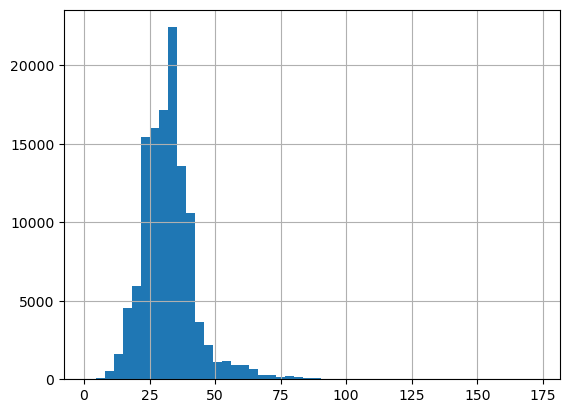

In [18]:
pd.Series(lengths).hist(bins=50)

In [19]:
MAX_LEN = int(np.percentile(lengths, 95)) 
MAX_LEN

50

### 데이터 전처리

In [20]:
# 어휘 사전
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(train_texts+valid_texts)

# 어휘 사전을 바탕으로 토큰을 정수화
train_sequences = tokenizer.texts_to_sequences(train_texts)
valid_sequences = tokenizer.texts_to_sequences(valid_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# 패딩을 통해 길이를 동일하게 고정
X_train = pad_sequences(train_sequences, maxlen=MAX_LEN, padding='post', truncating='post') # 50보다 긴건 잘림, 짧은건 post padding으로 인해 뒤에 0으로 채워짐
X_valid = pad_sequences(valid_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
X_test = pad_sequences(test_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

In [21]:
X_test[0]

array([ 2020,  3368,   450,    16,  6878, 36862,   253,    61,    34,
           1,    29,   290,    13,  9084,  2184,   372,   170,  9375,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0])

In [22]:
train_labels

array([0, 1, 0, ..., 1, 1, 2], dtype=int64)

In [23]:
# 위에 있는 정수로 해도 되지만 원 핫 인코딩으로 해봄, 정수일때는 sparse_categorical_crossentropy 사용
# 정답 데이터(기사 카테고리)를 원핫 인코딩 : categorical_crossentropy 사용
y_train = to_categorical(train_labels)
y_valid = to_categorical(valid_labels)
y_test = to_categorical(test_labels)

## 4. 모델 생성: `NewsClassifier`

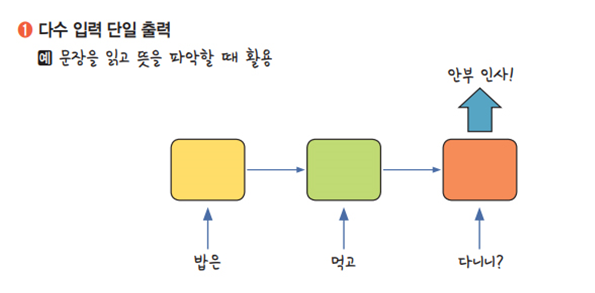

In [25]:
# 모델 하이퍼파라미터
VOCAB_SIZE = vocab_size  # 실제 어휘 사전 크기
EMBEDDING_SIZE = 100
HIDDEN_DIM = 50
MAX_LEN = MAX_LEN  # 실제 최대 시퀀스 길이
NUM_CLASSES = 4

BATCH_SIZE = 16
MAX_EPOCHS = 3

# NUM_LAYERS = 2
# DROPOUT_RATE = 0.2
# LSTM_HIDDEN_DIM = 100

In [27]:
# todo (모델 생성)
# Embedding
# RNN
# Dense(softmax) # 기사의 종류 예측
import tensorflow as tf
from tensorflow.keras import layers

model1 = tf.keras.Sequential([
    layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_SIZE, input_length=MAX_LEN), 
    layers.SimpleRNN(units=HIDDEN_DIM, return_sequences=False),
    layers.Dense(units=NUM_CLASSES, activation='softmax') 
])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           1633700   
                                                                 
 simple_rnn (SimpleRNN)      (None, 50)                7550      
                                                                 
 dense (Dense)               (None, 4)                 204       
                                                                 
Total params: 1,641,454
Trainable params: 1,641,454
Non-trainable params: 0
_________________________________________________________________


In [29]:
# todo (모델 설정) : optimizer, loss 설정, 성능 평가
model1.compile(optimizer=tf.keras.optimizers.Adam(0.001),
               loss='categorical_crossentropy',
               metrics=["accuracy"])

## 모델 훈련

In [ ]:
history = model1.fit(X_train, y_train,
                     batch_size=BATCH_SIZE,
                     epochs=MAX_EPOCHS,
                     validation_data=(X_valid, y_valid))

Epoch 1/3
6000/6000 [==============================] - 644s 107ms/step - loss: 1.1839 - accuracy: 0.4246 - val_loss: 0.6824 - val_accuracy: 0.7164
Epoch 2/3
6000/6000 [==============================] - 575s 96ms/step - loss: 0.5164 - accuracy: 0.8132 - val_loss: 0.3818 - val_accuracy: 0.8749
Epoch 3/3
6000/6000 [==============================] - ETA: 0s - loss: 0.3484 - accuracy: 0.8860

## 모델 예측

In [54]:
def predict_category(text, model, tokenizer, max_len=100):
    # 1. 텍스트를 시퀀스로 변환 및 패딩
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_len)

    # 2. 모델 예측
    proba = model.predict(padded, verbose=False)[0]
    predict = np.argmax(proba) + 1  # 0번 클래스를 1번으로 매핑
    probability = np.max(proba)
    return predict, probability

# 테스트 샘플 준비
test_samples = {}
for category in test_news_df['Class Index'].unique():
    test_samples[category] = test_news_df[test_news_df['Class Index'] == category]['Description'].tolist()[-5:]

category_map = {1:"World", 2:"Sports", 3:"Business", 4:"Sci/Tech"}

# 예측 실행
for truth, samples in test_samples.items():
    print(f"True Category: {category_map[truth]}")
    print('='*50)
    for sample in samples:
        predict, probability = predict_category(sample, model, tokenizer, max_len)
        print(f"예측: {category_map[predict]} (p={probability:.2f})")
        print(f"샘플: {sample}")
        print('-'*30)
    print()


True Category: Business
예측: World (p=0.62)
샘플: MOSCOW (AFP) - Russia forged ahead with the weekend auction of the core asset of crippled oil giant Yukos despite a disputed US court order barring the sale, with state-controlled gas giant Gazprom entering the bidding.
------------------------------
예측: Business (p=0.97)
샘플: The head of plane maker Airbus yesterday won a bitter battle to oust his boss from the helm of parent aerospace group Eads after winning the support of a key shareholder.
------------------------------
예측: Business (p=0.72)
샘플: Standard  amp; Poor #39;s Equity Research said the purchase of Rent.com by eBay (nasdaq: EBAY - news - people ) could be a bit of a miscalculation.
------------------------------
예측: Business (p=0.99)
샘플: SINGAPORE : Doctors in the United States have warned that painkillers Bextra and Celebrex may be linked to major cardiovascular problems and should not be prescribed.
------------------------------
예측: Business (p=0.94)
샘플: EBay plans to buy t

## 모델 평가

In [52]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

238/238 [==============================] - 3s 7ms/step - loss: 0.3112 - accuracy: 0.9013
Test Accuracy: 0.9013
